In [ ]:
!pip install --quiet pdfplumber PyMuPDF sentence-transformers faiss-cpu
!pip install streamlit ngrok pdfplumber matplotlib seaborn faiss-cpu sentence-transformers --quiet
!pip install google-cloud-vision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 456.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5

In [ ]:
import pdfplumber
import numpy as np
import faiss
import pickle
import csv
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from sentence_transformers import SentenceTransformer
import re
import sys


Saving order_10248.pdf to order_10248.pdf
Uploaded file: order_10248.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Financial data extraction complete. Saved to 'financials.csv'.


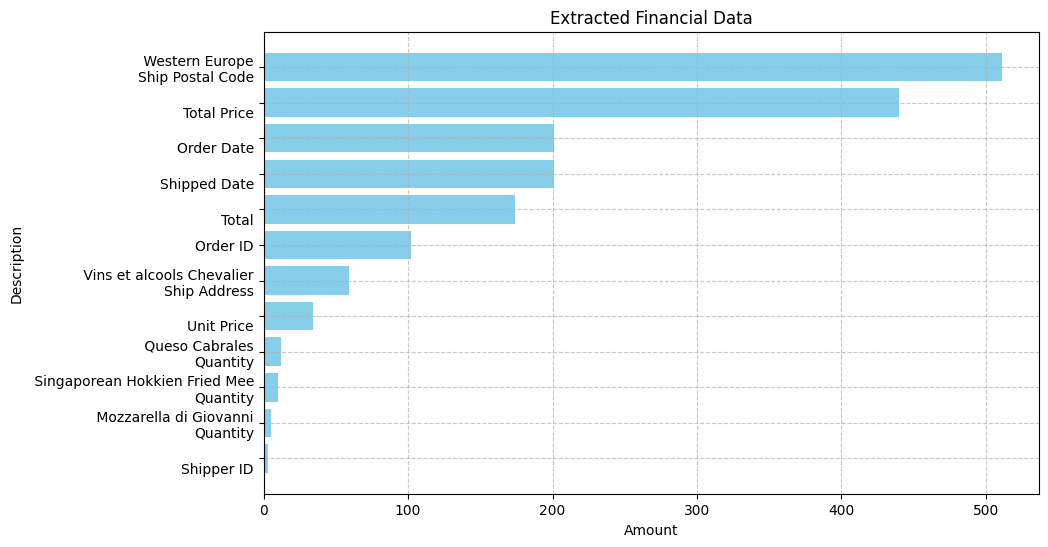

In [ ]:
# Uploading
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]
print(f"Uploaded file: {pdf_path}")

# Step 2: Extract Text from PDF with Error Handling
def extract_text_from_pdf(pdf_path):
    try:
        with pdfplumber.open(pdf_path) as pdf:
            text = ""
            for page_num, page in enumerate(pdf.pages):
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
            if not text.strip():
                raise ValueError("No readable text found in the PDF.")
            return text
    except Exception as e:
        sys.exit(f"Error extracting text: {e}")

extracted_text = extract_text_from_pdf(pdf_path)
text_sentences = [line.strip().lower() for line in extracted_text.split("\n") if line.strip()]

def extract_financials(text):
    pattern = r'([A-Za-z\s]+)\s*[:\-]?\s*(\$?\d{1,3}(?:,\d{3})*(?:\.\d{2})?)'
    matches = re.findall(pattern, text)
    df = pd.DataFrame(matches, columns=["Description", "Amount"])
    df['Amount'] = df['Amount'].replace({'\\$': '', ',': ''}, regex=True).astype(float)
    df = df.sort_values(by="Amount", ascending=False)
    return df

financial_df = extract_financials(extracted_text)

financial_df.to_csv("financials.csv", index=False)
files.download("financials.csv")
print("Financial data extraction complete. Saved to 'financials.csv'.")


plt.figure(figsize=(10, 6))
plt.barh(financial_df['Description'], financial_df['Amount'], color='skyblue')
plt.xlabel('Amount')
plt.ylabel('Description')
plt.title('Extracted Financial Data')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Embeddings and FAISS Index
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(text_sentences)
np.save("embeddings.npy", embeddings)
with open("sentences.pkl", "wb") as f:
    pickle.dump(text_sentences, f)
files.download("embeddings.npy")
files.download("sentences.pkl")

index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)
faiss.write_index(index, "faiss_index.index")
files.download("faiss_index.index")
print("FAISS index created and downloaded.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FAISS index created and downloaded.


In [ ]:
# Load
embeddings = np.load("embeddings.npy")
index = faiss.read_index("faiss_index.index")

# Load text
with open("sentences.pkl", "rb") as f:
    text_sentences = pickle.load(f)

print(f"Loaded {len(text_sentences)} sentences and FAISS index with {index.ntotal} entries.")


Loaded 37 sentences and FAISS index with 37 entries.


In [ ]:
# Load FAISS index and sentences
embeddings = np.load("embeddings.npy")
index = faiss.read_index("faiss_index.index")
with open("sentences.pkl", "rb") as f:
    text_sentences = pickle.load(f)

# Load embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

def search_financial_query(query, top_k=5):
    query_embedding = embedding_model.encode([query])
    distances, indices = index.search(query_embedding, top_k)
    results = [(text_sentences[i], distances[0][j]) for j, i in enumerate(indices[0])]
    return results

# Example Query
query = "Total revenue for Q4"
results = search_financial_query(query)

print(f"Results for query: '{query}'")
for text, distance in results:
    print(f"- {text} (Distance: {distance:.4f})")


Results for query: 'Total revenue for Q4'
- total: 174.0 (Distance: 1.1500)
- total: 168.0 (Distance: 1.1606)
- total price: (Distance: 1.1889)
- total: 98.0 (Distance: 1.1942)
- total price: 440.0 (Distance: 1.2827)


In [ ]:
import pandas as pd
import numpy as np
import re

financial_df = pd.read_csv("financials.csv")


def generate_financial_summary(df):
    total_amount = df['Amount'].sum()
    average_amount = df['Amount'].mean()
    median_amount = df['Amount'].median()
    top_expense = df.loc[df['Amount'].idxmax()]
    lowest_expense = df.loc[df['Amount'].idxmin()]


    high_value_transactions = df[df['Amount'] > average_amount]
    frequent_expense_categories = df['Description'].value_counts().head(3)


    summary = {
        "Total Amount": f"The total sum of all financial transactions is ${total_amount:.2f}.",
        "Average Transaction": f"The average transaction amount is ${average_amount:.2f}.",
        "Median Transaction": f"The median transaction amount, representing the midpoint of all transactions, is ${median_amount:.2f}.",
        "Highest Expense": f"The largest single expense recorded is {top_expense['Description']} totaling ${top_expense['Amount']:.2f}.",
        "Lowest Expense": f"The smallest single expense is {lowest_expense['Description']} at ${lowest_expense['Amount']:.2f}.",
        "Number of Transactions": f"A total of {len(df)} transactions were recorded.",
        "High-Value Transactions Count": f"There are {len(high_value_transactions)} transactions exceeding the average amount.",
        "Top Expense Categories": f"The most frequent expense categories are {frequent_expense_categories.to_dict()}"
    }
    return summary


summary = generate_financial_summary(financial_df)
print("Enhanced Financial Summary with Descriptions and Key Insights:")
for key, value in summary.items():
    print(f"{key}: {value}")


Enhanced Financial Summary with Descriptions and Key Insights:
Total Amount: The total sum of all financial transactions is $2041.00.
Average Transaction: The average transaction amount is $127.56.
Median Transaction: The median transaction amount, representing the midpoint of all transactions, is $78.50.
Highest Expense: The largest single expense recorded is  Western Europe
Ship Postal Code totaling $511.00.
Lowest Expense: The smallest single expense is 
Shipper ID at $3.00.
Number of Transactions: A total of 16 transactions were recorded.
High-Value Transactions Count: There are 6 transactions exceeding the average amount.
Top Expense Categories: The most frequent expense categories are {'\nTotal': 3, '\nUnit Price': 3, ' Western Europe\nShip Postal Code': 1}


<ipython-input-8-37b842600f13>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_expenses['Description'], x=top_expenses['Amount'], palette="viridis")


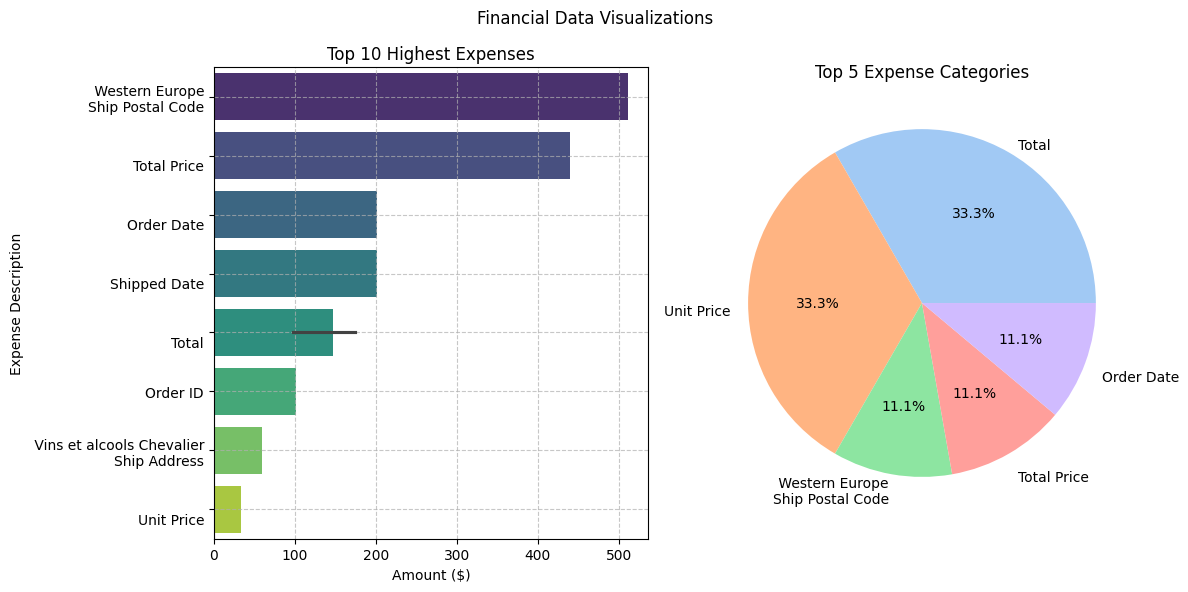

Step 4: Visualization of Financial Insights completed. Bar and pie charts generated.


In [ ]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


financial_df = pd.read_csv("financials.csv")


plt.figure(figsize=(12, 6))

# Bar chart
top_expenses = financial_df.nlargest(10, 'Amount')
plt.subplot(1, 2, 1)
sns.barplot(y=top_expenses['Description'], x=top_expenses['Amount'], palette="viridis")
plt.title('Top 10 Highest Expenses')
plt.xlabel('Amount ($)')
plt.ylabel('Expense Description')
plt.grid(True, linestyle='--', alpha=0.7)

# Pie chart
category_counts = financial_df['Description'].value_counts().head(5)
plt.subplot(1, 2, 2)
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Top 5 Expense Categories')

plt.suptitle('Financial Data Visualizations')
plt.tight_layout()
plt.show()

print("Step 4: Visualization of Financial Insights completed. Bar and pie charts generated.")


# New Section

In [ ]:
!pip install streamlit

In [ ]:
from transformers import pipeline
from PIL import Image
from sentence_transformers import SentenceTransformer, util
import requests

qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")
embedder = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


In [ ]:
pip install scipy


In [ ]:
!pip install streamlit pandas pdfplumber openpyxl transformers sentence-transformers seaborn

In [ ]:
!pip install statsmodels

python3: can't open file '/content/dashboard.py': [Errno 2] No such file or directory


In [ ]:
!pip install dash plotly

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.2 MB/s eta 0:00:00
  Created wheel for stringcase: filename=stringcase-1.2.0-py3-none-any.whl size=3568 sha256=235f358187313decc138607eaeac96dc6559e81357a3800cd8611b04faca871d
  Stored in directory: /root/.cache/pip/wheels/b4/33/6d/d0820be98063da218c3206fbad2381cd2db3fbb1a0f0d254b5
Successfully built stringcase
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [39]:
!pip install streamlit-aggrid


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 23.2 MB/s eta 0:00:00


In [46]:
%%writefile app.py
from scipy import stats
import streamlit as st
import pandas as pd
import pdfplumber
import seaborn as sns
import io
import base64
import openpyxl
import re
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import tkinter as tk
from st_aggrid import AgGrid
from tkinter import filedialog
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from statistics import mean
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util



# Streamlit UI Configuration
st.set_page_config(page_title="FinancialSage", page_icon="☾𖤓", layout="wide")

# Load NLP Models
@st.cache_resource
def load_qa_pipeline():
    return pipeline("question-answering", model="deepset/roberta-base-squad2")

@st.cache_resource
def load_embedder():
    return SentenceTransformer('all-MiniLM-L6-v2')

qa_pipeline = load_qa_pipeline()
embedder = load_embedder()

# .

def extract_text_from_pdf(pdf_file):
    text = ""
    try:
        with pdfplumber.open(pdf_file) as pdf:
            for page in pdf.pages:
                text += page.extract_text() or ""
    except Exception as e:
        st.error(f"Error processing PDF: {e}")
        return ""
    return text

def extract_financials(text):
    pattern = r'([A-Za-z0-9,\.\-\(\)\s]+)\s*[:\-]?\s*([\\$]?\d+(?:,\d{3})*(?:\.\d{2})?)'
    matches = re.findall(pattern, text)

    df = pd.DataFrame(matches, columns=["Description", "Amount"])
    df["Description"] = df["Description"].str.strip()
    df = df[df["Description"] != ""]

    try:
        df["Amount"] = (
            df["Amount"]
            .replace({"\\$": "", ",": ""}, regex=True)
            .astype(float)
        )
    except ValueError as e:
        st.error(f"Error converting amounts: {e}")
        return pd.DataFrame(columns=["Description", "Amount", "Formatted Amount"])

    df.dropna(subset=["Amount"], inplace=True)
    df.drop_duplicates(inplace=True)
    df["Formatted Amount"] = df["Amount"].apply(lambda x: f"${x:,.2f}")
    df.reset_index(drop=True, inplace=True)

    return df

def create_visualization(data, chart_type, x_col, y_col):
    fig = go.Figure()

    if chart_type == "Bar Chart":
        fig.add_trace(go.Bar(x=data[x_col], y=data[y_col]))
    elif chart_type == "Line Chart":
        fig.add_trace(go.Scatter(x=data[x_col], y=data[y_col], mode='lines+markers'))
    elif chart_type == "Pie Chart":
        fig.add_trace(go.Pie(labels=data[x_col].head(8), values=data[y_col].head(8)))
    elif chart_type == "Scatter Plot":
        fig.add_trace(go.Scatter(x=data[x_col], y=data[y_col], mode='markers'))
    elif chart_type == "Box Plot":
        fig.add_trace(go.Box(x=data[x_col], y=data[y_col]))
    elif chart_type == "Histogram":
        fig.add_trace(go.Histogram(x=data[y_col]))

    fig.update_layout(
        title=f"{chart_type} - {x_col} vs {y_col}",
        xaxis_title=x_col,
        yaxis_title=y_col,
        height=400
    )

    return fig

def detect_anomalies_advanced(df, feature_columns=['Amount'], contamination=0.1, source_column='Source'):
    """
    Detect anomalies using Isolation Forest with multiple features
    """
    anomalies_list = []
    feature_columns = [col for col in feature_columns if col in df.columns]

    if not feature_columns:
        return pd.DataFrame()

    # Handle multiple sources if present
    if source_column in df.columns:
        for source in df[source_column].unique():
            source_df = df[df[source_column] == source].copy()
            if len(source_df) < 10:  # Minimum samples needed
                continue

            # Prepare features
            X = source_df[feature_columns]

            # Fit Isolation Forest
            iso_forest = IsolationForest(contamination=contamination, random_state=42)
            anomaly_labels = iso_forest.fit_predict(X)

            # Add anomaly scores
            anomaly_scores = iso_forest.decision_function(X)
            source_anomalies = source_df[anomaly_labels == -1].copy()
            source_anomalies['anomaly_score'] = anomaly_scores[anomaly_labels == -1]
            anomalies_list.append(source_anomalies)

        anomalies = pd.concat(anomalies_list) if anomalies_list else pd.DataFrame()
    else:
        X = df[feature_columns]
        if len(X) < 10:
            return pd.DataFrame()

        iso_forest = IsolationForest(contamination=contamination, random_state=42)
        anomaly_labels = iso_forest.fit_predict(X)
        anomaly_scores = iso_forest.decision_function(X)
        anomalies = df[anomaly_labels == -1].copy()
        anomalies['anomaly_score'] = anomaly_scores[anomaly_labels == -1]

    return anomalies

def generate_sample_data(start_date, periods=365, sources=None):
    """
    Generate sample time series data for multiple sources
    """
    if sources is None:
        sources = ['Sample Data']

    all_data = []
    for source in sources:
        dates = pd.date_range(start=start_date, periods=periods, freq='D')
        np.random.seed(hash(source) % 2**32)

        trend = np.linspace(1000, 2000, periods)
        seasonality = 500 * np.sin(np.linspace(0, 4*np.pi, periods))
        noise = np.random.normal(0, 100, periods)

        values = trend + seasonality + noise

        df = pd.DataFrame({
            'Date': dates,
            'Amount': values,
            'Source': source
        })
        all_data.append(df)

    return pd.concat(all_data, ignore_index=True)


def plot_anomalies(df, anomalies, column='Amount', source_column='Source'):
    """
    Create visualization for anomalies with support for multiple sources
    """
    fig = go.Figure()
    sources = df[source_column].unique() if source_column in df.columns else [None]
    colors = px.colors.qualitative.Set3[:len(sources)]

    for idx, source in enumerate(sources):
        source_df = df[df[source_column] == source] if source else df
        source_anomalies = anomalies[anomalies[source_column] == source] if source else anomalies

        fig.add_trace(go.Scatter(
            x=source_df.index,
            y=source_df[column],
            mode='markers',
            name=f'Normal ({source if source else "Combined"})',
            marker=dict(color=colors[idx], size=8)
        ))

        if not source_anomalies.empty:
            fig.add_trace(go.Scatter(
                x=source_anomalies.index,
                y=source_anomalies[column],
                mode='markers',
                name=f'Anomaly ({source if source else "Combined"})',
                marker=dict(color='red', size=12, symbol='x')
            ))

    fig.update_layout(
        title='Advanced Anomaly Detection Results',
        xaxis_title='Index',
        yaxis_title=column,
        height=400
    )
    return fig


def create_advanced_analytics_tab(df):
    st.header("Advanced Analytics")

    advanced_analysis = st.radio(
        "Select Analysis Type:",
        ["Anomaly Detection"]
    )

    if advanced_analysis == "Anomaly Detection":
        st.subheader("Anomaly Detection")

        # Get numerical columns for feature selection
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

        if numeric_cols:
            feature_cols = st.multiselect(
                "Select features for anomaly detection",
                options=numeric_cols,
                default=['Amount'] if 'Amount' in numeric_cols else numeric_cols[:1]
            )

            contamination = st.slider(
                "Contamination level (expected anomaly proportion)",
                0.01, 0.5, 0.1, 0.01
            )

            anomalies = detect_anomalies_advanced(
                df,
                feature_columns=feature_cols,
                contamination=contamination,
                source_column='Source' if 'Source' in df.columns else None
            )

            if not anomalies.empty:
                st.write(f"Found {len(anomalies)} anomalies")
                fig = plot_anomalies(df, anomalies, feature_cols[0], 'Source' if 'Source' in df.columns else None)
                st.plotly_chart(fig, use_container_width=True)

                st.subheader("Anomalous Transactions")
                st.dataframe(anomalies)
            else:
                st.info("No anomalies detected with current settings")
        else:
            st.warning("No numerical columns available for anomaly detection")

from statsmodels.tsa.seasonal import seasonal_decompose
def create_financial_predictions_tab(df):
    st.header("📈 Financial Predictions & Forecasting")

    if 'Date' not in df.columns or 'Amount' not in df.columns:
        st.warning("Ensure your file has 'Date' and 'Amount' columns for predictions.")
        return

    # Convert Date column and aggregate daily sum
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[['Date', 'Amount']].dropna()
    df = df.groupby('Date').sum().asfreq('D', fill_value=0)  # Ensure daily frequency

    # User Inputs
    future_days = st.slider("📅 Select number of days to predict:", 7, 365, 30)
    target_amount = st.number_input("🎯 Enter a target amount (optional):", min_value=0.0, value=0.0, step=100.0)

    # **Step 1: Time Series Decomposition**
    st.subheader("🔍 Seasonal Decomposition")
    decomposition = seasonal_decompose(df['Amount'], model='additive')
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))

    axes[0].plot(df.index, decomposition.trend, label="Trend", color="blue")
    axes[0].set_title("Trend")
    axes[1].plot(df.index, decomposition.seasonal, label="Seasonality", color="green")
    axes[1].set_title("Seasonality")
    axes[2].plot(df.index, decomposition.resid, label="Residuals", color="red")
    axes[2].set_title("Residuals")

    plt.tight_layout()
    st.pyplot(fig)

    # **Step 2: Train ARIMA Model with Dynamic Order Selection**
    st.subheader("📊 ARIMA Forecasting")
    try:
        model = ARIMA(df['Amount'], order=(2, 1, 2))  # Adjust order dynamically if needed
        fitted_model = model.fit()
    except Exception as e:
        st.error(f"Error in ARIMA Model Training: {e}")
        return

    # **Step 3: Forecasting**
    forecast = fitted_model.get_forecast(steps=future_days)
    forecast_ci = forecast.conf_int()  # Confidence Interval
    forecast_dates = pd.date_range(start=df.index[-1], periods=future_days + 1, freq='D')[1:]

    # Convert to DataFrame
    forecast_df = pd.DataFrame({'Date': forecast_dates, 'Predicted Amount': forecast.predicted_mean})
    forecast_df['Lower Bound'] = forecast_ci.iloc[:, 0]
    forecast_df['Upper Bound'] = forecast_ci.iloc[:, 1]

    # **Step 4: Visualization**
    fig = go.Figure()

    # Historical Data
    fig.add_trace(go.Scatter(x=df.index, y=df['Amount'], mode='lines', name="📜 Historical Data", line=dict(color='blue')))

    # Forecasted Data
    fig.add_trace(go.Scatter(x=forecast_df['Date'], y=forecast_df['Predicted Amount'], mode='lines', name="🔮 Predicted Data", line=dict(color='green')))

    # Confidence Interval
    fig.add_trace(go.Scatter(x=forecast_df['Date'], y=forecast_df['Upper Bound'], mode='lines', name="🔺 Upper Bound", line=dict(color='red', dash='dot')))
    fig.add_trace(go.Scatter(x=forecast_df['Date'], y=forecast_df['Lower Bound'], mode='lines', name="🔻 Lower Bound", line=dict(color='red', dash='dot')))

    fig.update_layout(title="Projected Financial Forecast", xaxis_title="Date", yaxis_title="Amount (₹)")
    st.plotly_chart(fig, use_container_width=True)

    # **Step 5: Summary Metrics**
    estimated_expense = forecast_df['Predicted Amount'].sum()
    avg_daily_spending = df['Amount'].mean()
    st.write(f"### 🏦 Estimated Expense over {future_days} days: **₹{estimated_expense:.2f}**")
    st.write(f"### 📊 Average Daily Spending: **₹{avg_daily_spending:.2f}**")

    # **Step 6: Time to Reach Target**
    if target_amount > 0:
        cumulative_spending = np.cumsum(forecast_df['Predicted Amount'])
        days_to_target = np.where(cumulative_spending >= target_amount)[0]
        if days_to_target.size > 0:
            estimated_days = days_to_target[0] + 1
            st.write(f"### 🎯 Estimated Time to Reach ₹{target_amount}: **{estimated_days} days**")
        else:
            st.warning("❗ Target amount may not be reached within the selected period.")

    # **Step 7: Additional Graphs**
    st.subheader("📊 Additional Insights")

    # 📌 Cumulative Trend
    cumulative_fig = px.line(forecast_df, x='Date', y=np.cumsum(forecast_df['Predicted Amount']),
                             title="Cumulative Financial Trend")
    st.plotly_chart(cumulative_fig, use_container_width=True)

    # 📌 Histogram of Amounts
    st.write("### 🔥 Distribution of Historical Amounts")
    hist_fig = px.histogram(df, x="Amount", nbins=20, title="Distribution of Amounts")
    st.plotly_chart(hist_fig, use_container_width=True)

    # 📌 Line Chart of Historical Data
    st.write("### 📈 Historical Financial Trend")
    line_chart = px.line(df, x=df.index, y="Amount", title="Historical Financial Data Over Time")
    st.plotly_chart(line_chart, use_container_width=True)

    return forecast_df

# Function to create styled card
def styled_card(title, value):
    st.markdown(
        f"""
        <div style="background-color: #f4f4f4; padding: 15px; border-radius: 10px; text-align: center;">
            <h4 style="color: #333;">{title}</h4>
            <h2 style="color: #007BFF;">{value}</h2>
        </div>
        """,
        unsafe_allow_html=True,
    )

# Function to generate dashboard
def interactive_dashboard(df):
    st.title("📊 Interactive Financial Analysis Dashboard")

    # Convert date columns
    date_cols = df.select_dtypes(include=['object']).columns.tolist()
    for col in date_cols:
        try:
            df[col] = pd.to_datetime(df[col], errors='coerce')
        except:
            pass  # Ignore columns that can't be converted

    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    # Sidebar Filters
    st.sidebar.header("🔍 Filter Data")
    selected_col = st.sidebar.selectbox("Filter by Column", df.columns)
    unique_values = df[selected_col].dropna().unique()
    selected_value = st.sidebar.selectbox("Select Value", unique_values)
    df = df[df[selected_col] == selected_value]

    # 🚀 **Key Financial Metrics (Styled Boxes)**
    col1, col2, col3, col4 = st.columns(4)

    with col1:
        styled_card("💰 Total Amount", f"${df[numeric_cols].sum().sum():,.2f}")
    with col2:
        styled_card("📈 Highest Transaction", f"${df[numeric_cols].max().max():,.2f}")
    with col3:
        styled_card("📉 Average Transaction", f"${df[numeric_cols].mean().mean():,.2f}")
    with col4:
        styled_card("🔄 Total Transactions", f"{df.shape[0]:,}")

    # 🚀 **Graph Layout in Grid System with Styled Boxes**
    col5, col6 = st.columns(2)

    with col5:
        st.markdown("<div style='background-color: #f9f9f9; padding: 15px; border-radius: 10px;'><h4>📊 Time Series Analysis</h4></div>", unsafe_allow_html=True)
        if date_cols:
            date_col = st.selectbox("Select Date Column", date_cols)
            df_sorted = df.dropna(subset=[date_col]).sort_values(by=date_col)
            time_series_fig = px.line(df_sorted, x=date_col, y=numeric_cols, title="Time Series Analysis")
            st.plotly_chart(time_series_fig, use_container_width=True)

    with col6:
        st.markdown("<div style='background-color: #f9f9f9; padding: 15px; border-radius: 10px;'><h4>📌 Correlation Heatmap</h4></div>", unsafe_allow_html=True)
        if len(numeric_cols) > 1:
            fig, ax = plt.subplots(figsize=(6, 4))
            sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', ax=ax)
            st.pyplot(fig)

    # 🚀 **Pivot Table & Raw Data View (Styled Boxes)**
    col7, col8 = st.columns(2)

    with col7:
        st.markdown("<div style='background-color: #f9f9f9; padding: 15px; border-radius: 10px;'><h4>🔄 Interactive Pivot Table</h4></div>", unsafe_allow_html=True)
        pivot_index = st.multiselect("Select Index Columns", df.columns.tolist())
        pivot_values = st.multiselect("Select Values", numeric_cols)
        pivot_aggfunc = st.selectbox("Select Aggregation Function", ["sum", "mean", "count", "max", "min"])

        if pivot_index and pivot_values:
            pivot_table = df.pivot_table(index=pivot_index, values=pivot_values, aggfunc=pivot_aggfunc)
            AgGrid(pivot_table)

    with col8:
        st.markdown("<div style='background-color: #f9f9f9; padding: 15px; border-radius: 10px;'><h4>📋 Raw Data View</h4></div>", unsafe_allow_html=True)
        AgGrid(df)

from transformers import T5Tokenizer, T5ForConditionalGeneration
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util

# Load tokenizer
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Load sentence transformer model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Load data into a DataFrame
def load_data(file_path):
    try:
        data_df = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        return data_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def generate_response(query, data_context):
    input_text = f"Context: {data_context} Query: {query}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    output_ids = model.generate(input_ids, max_length=150, num_beams=5, early_stopping=True)
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return response

def rephrase_response(response):
    input_text = f"Rephrase: {response}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    output_ids = model.generate(input_ids, max_length=150, num_beams=5, early_stopping=True)
    rephrased_response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return rephrased_response

def process_query(query, data_df, text_content=""):
    specific_questions = {
        "what is the document about": "This document provides a detailed analysis of financial transactions, including descriptions and amounts.",
        "describe the document": "The document contains financial data extracted from various sources, organized into categories and amounts.",
        "explain this document": "This document summarizes financial transactions, highlighting key metrics and insights.",
        "total unique item sales": f"Total unique item sales: {data_df['Description'].nunique()}",
        "total products bought": f"Total products bought: {data_df['Amount'].count()}"
    }


    query_lower = query.lower()
    if query_lower in specific_questions:
        return specific_questions[query_lower], 1.0

# nlp
    if text_content:
        try:
            embeddings = embedder.encode([query, text_content], convert_to_tensor=True)
            similarity_score = util.pytorch_cos_sim(embeddings[0], embeddings[1])
            result = qa_pipeline(question=query, context=text_content)
            return result['answer'], similarity_score.item()
        except Exception as e:
            return f"Error processing query: {e}", 0.0
    else:
#Analyse the data.
        try:
            numeric_cols = data_df.select_dtypes(include=[np.number]).columns
            response = []

            if 'average' in query_lower or 'mean' in query_lower:
                for col in numeric_cols:
                    response.append(f"Average {col}: ${data_df[col].mean():,.2f}")
            elif 'maximum' in query_lower or 'highest' in query_lower:
                for col in numeric_cols:
                    response.append(f"Maximum {col}: ${data_df[col].max():,.2f}")
            elif 'minimum' in query_lower or 'lowest' in query_lower:
                for col in numeric_cols:
                    response.append(f"Minimum {col}: ${data_df[col].min():,.2f}")
            elif 'total' in query_lower or 'sum' in query_lower:
                for col in numeric_cols:
                    response.append(f"Total {col}: ${data_df[col].sum():,.2f}")
            else:
                response.append("I can answer questions about averages, maximums, minimums, and totals in your data.")

            return "\n".join(response), 1.0
        except Exception as e:
            return f"Error analyzing data: {e}", 0.0


# Main.
def main():
    st.title("☾𖤓 Financial Sage")

    with st.sidebar:
        st.header("Upload Options")
        upload_type = st.radio("Choose upload type:", ["Single File", "Multiple Files"])

    if upload_type == "Single File":
        uploaded_file = st.file_uploader(
            "Upload a financial document:",
            type=["csv", "xlsx", "pdf"]
        )

        if uploaded_file:
            st.header(f"Processing: {uploaded_file.name}")

            # Process
            if uploaded_file.name.endswith('.pdf'):
                text_content = extract_text_from_pdf(uploaded_file)
                with st.expander("📄 Document Content", expanded=True):
                    st.text_area("Content:", text_content, height=200)
                df = extract_financials(text_content)
            else:
                try:
                    df = pd.read_excel(uploaded_file) if uploaded_file.name.endswith('.xlsx') else pd.read_csv(uploaded_file)
                    text_content = ""
                except Exception as e:
                    st.error(f"Error reading file: {e}")
                    return

            tab1, tab2, tab3, tab4, tab5, tab6 = st.tabs(["Data Analysis", "Visualizations", "Interactive Dashboard", "Query Tool", "Advanced Analytics","Financial Forecasting"])

            with tab1:
                st.dataframe(df)
                csv = df.to_csv(index=False).encode('utf-8')
                st.download_button(
                    "📥 Download Data (CSV)",
                    csv,
                    f"processed_{uploaded_file.name}.csv",
                    "text/csv"
                )

            with tab2:
                numeric_cols = df.select_dtypes(include=[np.number]).columns
                selected_charts = st.multiselect(
                    "Select charts to generate:",
                    ["Bar Chart", "Line Chart", "Pie Chart", "Scatter Plot", "Box Plot", "Histogram"],
                    default=["Bar Chart"]
                )

                if selected_charts:
                    col1, col2 = st.columns(2)
                    with col1:
                        x_col = st.selectbox("Select X-axis:", df.columns)
                    with col2:
                        y_col = st.selectbox("Select Y-axis:", numeric_cols)

                    if st.button("Generate Charts"):
                        for chart_type in selected_charts:
                            fig = create_visualization(df, chart_type, x_col, y_col)
                            st.plotly_chart(fig, use_container_width=True)

            with tab3:
              interactive_dashboard(df)

            with tab4:
                query = st.text_input("Enter your question about the data:")
                if query:
                    answer, confidence = process_query(query, df, text_content)
                    st.write(f"**Answer:** {answer}")
                    if confidence > 0:
                        st.write(f"**Confidence Score:** {confidence:.2f}")

            with tab5:
                 create_advanced_analytics_tab(df)

            with tab6:
                create_financial_predictions_tab(df)

    else:  # Multiple Files
        uploaded_files = st.file_uploader(
            "Upload multiple documents:",
            accept_multiple_files=True,
            type=["csv", "xlsx", "pdf"]
        )

        if uploaded_files:
            all_dfs = {}
            combined_text = ""

            for file in uploaded_files:
                with st.expander(f"📄 {file.name}", expanded=True):
                    if file.name.endswith('.pdf'):
                        text = extract_text_from_pdf(file)
                        combined_text += text
                        st.text_area("Content:", text, height=200)
                        df = extract_financials(text)
                    else:
                        try:
                            df = pd.read_excel(file) if file.name.endswith('.xlsx') else pd.read_csv(file)
                        except Exception as e:
                            st.error(f"Error reading {file.name}: {e}")
                            continue

                    df['Source'] = file.name
                    all_dfs[file.name] = df

                    st.dataframe(df)
                    csv = df.to_csv(index=False).encode('utf-8')
                    st.download_button(
                        f"📥 Download {file.name} Data",
                        csv,
                        f"processed_{file.name}.csv",
                        "text/csv"
                    )

            if all_dfs:
                combined_df = pd.concat(all_dfs.values(), ignore_index=True)
                # Ensure combined DataFrame has an index
                if combined_df.index.name is None:
                    combined_df = combined_df.reset_index(drop=True)
                tab1, tab2, tab3, tab4, tab5 = st.tabs(["Combined Data", "Visualizations", "Interactive Dashboard", "Query Tool","Advanced Analytics"])

                with tab1:
                    st.dataframe(combined_df)
                    combined_csv = combined_df.to_csv(index=False).encode('utf-8')
                    st.download_button(
                        "📥 Download Combined Data",
                        combined_csv,
                        "combined_analysis.csv",
                        "text/csv"
                    )

                with tab2:
                    numeric_cols = combined_df.select_dtypes(include=[np.number]).columns
                    selected_charts = st.multiselect(
                        "Select charts to generate:",
                        ["Bar Chart", "Line Chart", "Pie Chart", "Scatter Plot", "Box Plot", "Histogram"],
                        default=["Bar Chart"]
                    )

                    if selected_charts:
                        col1, col2 = st.columns(2)
                        with col1:
                            x_col = st.selectbox("Select X-axis:", combined_df.columns)
                        with col2:
                            y_col = st.selectbox("Select Y-axis:", numeric_cols)

                        if st.button("Generate Charts"):
                            for chart_type in selected_charts:
                                fig = create_visualization(combined_df, chart_type, x_col, y_col)
                                st.plotly_chart(fig, use_container_width=True)

                with tab3:
                  interactive_dashboard(combined_df)

                with tab4:
                  query = st.text_input("Enter your question about the combined data:")
                  if query:
                    answer, confidence = process_query(query, combined_df, combined_text)
                    st.write(f"**Answer:** {answer}")
                    if confidence > 0:
                      st.write(f"**Confidence Score:** {confidence:.2f}")

                with tab5:
                  create_advanced_analytics_tab(combined_df)

                with tab6:
                  create_financial_predictions_tab(combined_df)



if __name__ == "__main__":
    main()

Overwriting app.py


In [ ]:
!pip install pyngrok --quiet
!ngrok config add-authtoken 2szpvdGz6Ms1XqMAjv68ZuAI0NM_5Kw7D3XSi6eQCGZ9nFCEu

import os
import signal
import subprocess
import time
from pyngrok import ngrok

# Function to kill all ngrok processes
def kill_ngrok():
    try:
        # Find and kill ngrok processes
        process = subprocess.Popen(['ps', '-aux'], stdout=subprocess.PIPE)
        output, _ = process.communicate()
        for line in output.decode('utf-8').splitlines():
            if 'ngrok' in line and 'start' not in line:  # Avoid killing the new ngrok process
                pid = int(line.split()[1])
                os.kill(pid, signal.SIGTERM)  # Terminate the process
        print("Killed all existing ngrok processes.")
    except Exception as e:
        print(f"Error killing ngrok processes: {e}")

# Start Streamlit in background
def start_streamlit():
    subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8502"])  # Changed to port 8502
    time.sleep(3)  # Give it time to start

# Launch Streamlit
start_streamlit()

# Expose URL with ngrok
ngrok.set_auth_token("2szpvdGz6Ms1XqMAjv68ZuAI0NM_5Kw7D3XSi6eQCGZ9nFCEu")

# Kill existing ngrok processes
kill_ngrok()
time.sleep(2)  # Give time for processes to terminate

# Disconnect all active tunnels
active_tunnels = ngrok.get_tunnels()
for tunnel in active_tunnels:
    print(f"Disconnecting tunnel: {tunnel.public_url}")
    ngrok.disconnect(tunnel.public_url)

# Start a new ngrok tunnel on a different port
public_url = ngrok.connect(8502)  # Changed to port 8502
print(f"Your Streamlit app is available at: {public_url}")




Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Killed all existing ngrok processes.


Disconnecting tunnel: https://0a8c-104-155-208-68.ngrok-free.app
Your Streamlit app is available at: NgrokTunnel: "https://85bf-104-155-208-68.ngrok-free.app" -> "http://localhost:8502"


In [ ]:
!ngrok config check

Valid configuration file at /root/.config/ngrok/ngrok.yml
